# 20OCT Factory Day Demo

This is a set of demo notebooks to illustrate the use of the MLTE library and SDMT process for the Factory Day scenario. This demo uses the "Dogs vs. Cats" dataset and scenario from the negotiation as guidance for the required Properties and Conditions.

## 0. Quality Attribute Scenarios

The following is a prioritized (but limited) list of the QASs that we want to validate through the use of MLTE. The examples below relate to the hypothetical system used by the Dogs are Dumb (DaD) Task Force to detect non-compliant service members who own dogs. The system used an ML model that was trained on the cats and dogs dataset located on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). 

* **Precision**
  * Beause the DaD cares about identifing dogs but NEVER missclassifying a cat as a dog (false posiive), this model will need to have a high precision rate. Precision is measured as the true positive rate divided by the true positive rate times the false positive rate. 
* **Robustness- Model Robust to Noise (Image Blur)**
  * Because the model will receive picture taken from a device mounted to the back of a cat, they will likely be a bit blurry. The model should still be able to successfully identify dogs at the same rate as non-blurry images. Test data needs to include blurred dog images.  Blurred images will be created using ImageMagick. For our purposes we will test against maximum blur. Blurry images are successfully identified at rates equal to that of non-blurred images. This will be measured using the Wilcoxon Rank-Sum test, with significance at p-value <=0.05.
* **Performance on Operational Platform**
  * The model will need to run on the devices worn on the back of cats. These are small, inexpensive devices with limited CPU power, as well as limited memory and disk space (512 MB and 128 GB, respectively). The original test dataset can be used. 1- Executing the model on the loaned platform will not exceed maximum CPU usage of 30% to ensure reasonable response time. CPU usage will be measure using ps. 2- Memory usage at inference time will not exceed available memory of 512 MB. This will be measured using pmap. 3 - Disk usage will not exceed available disk space of 128 GB. This will be measured using by adding the size of each file in the path for the model code.

## 1. Define a Specification

In the first phase of SDMT, we define a `Specification` that represents the requirements the completed model must meet in order to be acceptable for use in the system into which it will be integrated.

#### Initialize MLTE Context

MLTE contains a global context that manages the currently active _session_. Initializing the context tells MLTE how to store all of the artifacts that it produces.

In [4]:
%pip install mlte-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
from mlte.session import set_context, set_store

store_path = os.path.join(os.getcwd(), "store")
os.makedirs(store_path, exist_ok=True)   # Ensure we are creating the folder if it is not there.

set_context("ns", "DogsVCats", "0.0.1")
set_store(f"local://{store_path}")

ModuleNotFoundError: No module named 'mlte.session'

#### Build a `Specification`

In MLTE, we define requirements by constructing a specification (`Spec`). For each property, we define the validations to perform as well. Note that several new `Value` types (`MultipleAccuracy`, `RankSums`, `MultipleRanksums`) had to be created to define the validation methods that will validate each Condition.

In [ ]:
from mlte.spec.spec import Spec

# The Properties we want to validate, associated with our scenarios.
from mlte.property.functionality import TaskEfficacy
from mlte.value.types.real import Real
from mlte.property.costs.storage_cost import StorageCost
from properties.robustness import Robustness
from properties.predicting_memory_cost import PredictingMemoryCost
from properties.predicting_compute_cost import PredictingComputeCost

# The Value types we will use to validate each condition.
from mlte.measurement.storage import LocalObjectSize
from mlte.measurement.cpu import LocalProcessCPUUtilization
from mlte.measurement.memory import LocalProcessMemoryConsumption
from mlte.value.types.image import Image
from values.multiple_accuracy import MultipleAccuracy
from values.ranksums import RankSums
from values.multiple_ranksums import MultipleRanksums

# The full spec. Note that the Robustness Property contains conditions for both Robustness scenarios.
spec = Spec(properties={
    TaskEfficacy("Important to understand if the model performance is appropiate for this case"): 
                    {"precision": Real.greater_or_equal_to(0.98)},
    Robustness("Robust against blur"): 
                {"ranksums blur2x8": RankSums.p_value_greater_or_equal_to(0.05/3),
                 "ranksums blur5x8": RankSums.p_value_greater_or_equal_to(0.05/3),
                 "ranksums blur0x8": RankSums.p_value_greater_or_equal_to(0.05/3),
                 "multiple ranksums for clade2": MultipleRanksums.all_p_values_greater_or_equal_than(0.05),
                 "multiple ranksums between clade2 and 3": MultipleRanksums.all_p_values_greater_or_equal_than(0.05),
                },
    StorageCost("Critical since model will be in an embedded device"): 
                    {"model size": LocalObjectSize.value().less_than(3000)},                
    PredictingMemoryCost("Useful to evaluate resources needed when predicting"): 
                    {"predicting memory": LocalProcessMemoryConsumption.value().average_consumption_less_than(512000.0)},
    PredictingComputeCost("Useful to evaluate resources needed when predicting"): 
                    {"predicting cpu": LocalProcessCPUUtilization.value().max_utilization_less_than(30.0)},
    })
spec.save(parents=True, force=True)

## 2. Initial Model Development

### 2.1 Enviornment Setup

This demo has an additional set of requirements than MLTE. You can install them from the file in this folder, with the command: 

In [ ]:
!pip --default-timeout 1000 install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot
from matplotlib.image import imread
% matplotlib inline

2023-10-14 20:52:00.402329: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-14 20:52:00.428742: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-14 20:52:00.428803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-14 20:52:00.428820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-14 20:52:00.435302: I tensorflow/core/platform/cpu_feature_g

2.14.0


### 2.2 Data Preperation

In order to satisfy the requirements defined in the initial negotiation with the DaD TF, you decide to develop a convolution neural network to classify images into two categories, dog or cat. You decide to use a publicly available dataset on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) to train your model. The dataset is comprised of photos of dogs and cats provided as a subset of photos from a much larger dataset of 3 million manually annotated photos. The dataset was developed as a partnership between Petfinder.com and Microsoft.

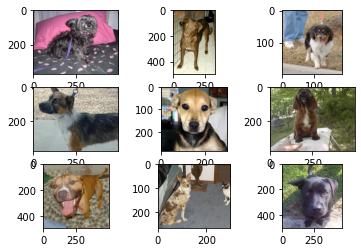

In [27]:
# examples of "dog" images
folder = 'data/train/'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

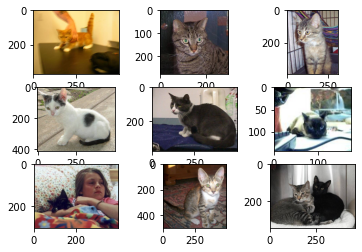

In [28]:
# examples of "cat" images
folder = 'data/train/'
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
pyplot.show()

In [29]:
# explore the breakdown of train and test images
training_images = "data/train"
test_images = "data/test"

train_size = len([name for name in os.listdir(training_images)])
test_size = len([name for name in os.listdir(test_images)])
print("Number of training images:", train_size)
print("Number of test images:", test_size)


Number of training images: 25002
Number of test images: 12502


In [5]:
IMAGE_WIDTH = IMAGE_HEIGHT = 150

Prepare file names and training data. Since you are developing a binary classifier, you label the target class of dogs as "1" and cats as "0"

In [6]:
filenames = os.listdir(training_images)
categories = []

Valid_Fraction = 0.2
Batch_Size = 100
Epochs = 100

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
categories = [str(i) for i in categories]
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

<AxesSubplot: >

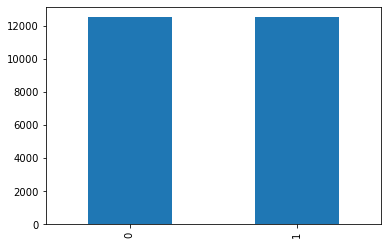

In [11]:
df['category'].value_counts().plot.bar()

In [14]:
# splitting to train & valid
train_df, valid_df = train_test_split(df, test_size=Valid_Fraction, random_state=10)

### 2.3 Generators

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 19999 validated image filenames belonging to 2 classes.


/home/jniemann/.local/lib/python3.11/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [16]:
# not doing any data augmentation on validation test set
valid_datagen  = ImageDataGenerator(rescale=1./255.)

validation_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 5001 validated image filenames belonging to 2 classes.


### 2.5 Training Model

In [19]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    patience=10)

### 2.6 Training

In [22]:
total_validate = int(valid_df.count()[0])
total_train = int(train_df.count()[0])

In [23]:
history = model.fit_generator(
    train_generator, 
    epochs=Epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//Batch_Size,
    steps_per_epoch=total_train//Batch_Size,
    callbacks=[es]
)

/tmp/ipykernel_95808/2871421910.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
200/200 [==============================] - 198s 982ms/step - loss: 0.7748 - accuracy: 0.6315 - val_loss: 1.5114 - val_accuracy: 0.4928
Epoch 2/100
200/200 [==============================] - 206s 1s/step - loss: 0.5606 - accuracy: 0.7163 - val_loss: 1.0890 - val_accuracy: 0.5660
Epoch 3/100
200/200 [==============================] - 211s 1s/step - loss: 0.4878 - accuracy: 0.7626 - val_loss: 0.5260 - val_accuracy: 0.7402
Epoch 4/100
200/200 [==============================] - 200s 997ms/step - loss: 0.4507 - accuracy: 0.7886 - val_loss: 0.5897 - val_accuracy: 0.7588
Epoch 5/100
200/200 [==============================] - 199s 992ms/step - loss: 0.4086 - accuracy: 0.8162 - val_loss: 0.4563 - val_accuracy: 0.7946
Epoch 6/100
200/200 [==============================] - 196s 980ms/step - loss: 0.3927 - accuracy: 0.8213 - val_loss: 0.4395 - val_accuracy: 0.8220
Epoch 7/100
200/200 [==============================] - 196s 980ms/step - loss: 0.3750 - accuracy: 0.8298 - val_loss: 0.5269 

In [32]:
model.save_weights("model.h5")

### 2.7 Testing Generator

In [46]:
test_filenames = os.listdir(test_images)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [47]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_images, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=Batch_Size,
    shuffle=False
)

Found 12500 validated image filenames.


### 2.8 Prediction

In [48]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/Batch_Size))
predict

/tmp/ipykernel_95808/2475604923.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/Batch_Size))


array([[8.9798540e-01],
       [9.5902296e-06],
       [2.5734317e-01],
       ...,
       [9.9318302e-01],
       [2.3129880e-05],
       [3.5787693e-01]], dtype=float32)

As predicted of binary classification result return probability that image likely to be a dog. So we will have threshold 0.5 which mean if predicted value more than 50% it is a dog and under 50% will be a cat.

In [52]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

<AxesSubplot: >

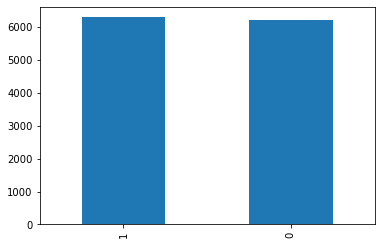

In [53]:
test_df['category'].value_counts().plot.bar()

### 2.9 Visualize Predictions

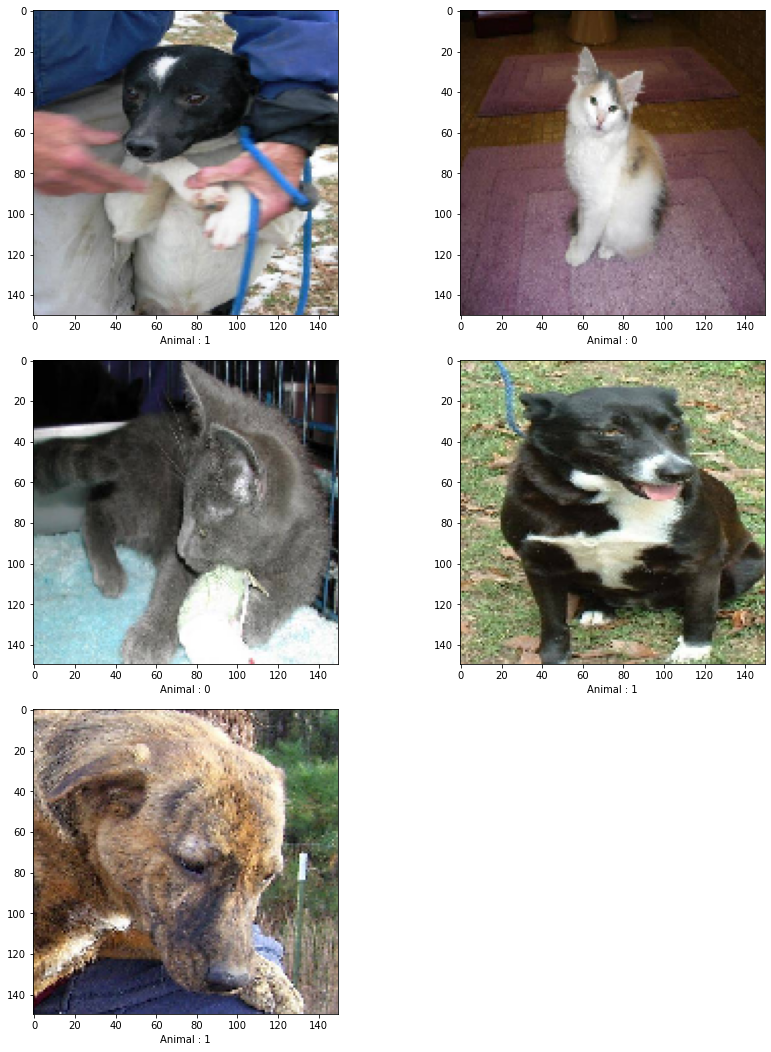

In [96]:
from matplotlib import pyplot as plt

sample_test = test_df.head(5)

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test/"+filename, target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    plt.subplot(5, 2, index+1)
    plt.imshow(img)
    plt.xlabel("Animal : " + str(category))
plt.tight_layout()
plt.show()

# 3. Collect Evidence

In the second phase of SDMT, we collect _evidence_ to attest to the fact that the model realized the properties specified in the previous phase.

We define and instantiate `Measurement`s to generate this evidence. Each individual piece of evidence is a `Value`. Once `Value`s are produced, we can persist them to an _artifact store_ to maintain our evidence across sessions. 

### Initialize MLTE Context

MLTE contains a global context that manages the currently active _session_. Initializing the context tells MLTE how to store all of the artifacts that it produces.

Define different folders that will be used as input or output for the data gathering process.

In [ ]:
from pathlib import Path

# The path at which datasets are stored
DATASETS_DIR = Path.cwd() / "data"

# Path where the model files are stored.
MODELS_DIR = Path.cwd() / "model"

# The path at which media is stored
MEDIA_DIR = Path.cwd() / "media"
os.makedirs(MEDIA_DIR, exist_ok=True)

### 3.1 Precision

In [34]:
import sklearn.metrics as metrics

predictions = model.predict_generator(validation_generator, steps=total_train//Batch_Size)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)

/tmp/ipykernel_95808/1876942931.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator, steps=total_train//Batch_Size)


/home/jniemann/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jniemann/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jniemann/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
print(report)

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2463
           1       0.00      0.00      0.00      2538

    accuracy                           0.49      5001
   macro avg       0.25      0.50      0.33      5001
weighted avg       0.24      0.49      0.33      5001



### 3.2 Robustness to Image Blur

In [ ]:
# General functions.
import pandas as pd


def calculate_base_accuracy(df_results: pd.DataFrame) -> pd.DataFrame:
    #Calculate the base model accuracy result per data label
    df_pos = df_results[df_results['model correct'] == True].groupby('label').count()
    df_pos.drop(columns = ['prediced_label'], inplace = True)
    df_neg = df_results[df_results['model correct'] == False].groupby('label').count()
    df_neg.drop(columns = ['prediced_label'], inplace = True)
    df_neg.rename(columns = {'model correct':'model incorrect'}, inplace = True)
    df_res = df_pos.merge(df_neg, right_on ='label', left_on = 'label', how = 'outer')
    df_res.fillna(0, inplace = True)
    df_res['model acc'] = df_res['model correct'] / ( df_res['model correct'] + df_res['model incorrect'] )
    df_res['count'] = ( df_res['model correct'] + df_res['model incorrect'] )
    df_res.drop(columns = ['model correct', 'model incorrect'], inplace = True)
    df_res.head()

    return df_res

def calculate_accuracy_per_set(data_folder: str, df_results: pd.DataFrame, df_res: pd.DataFrame) -> pd.DataFrame:
    #Calculate the model accuracy per data label for each blurred data set
    base_filename = 'FlowerModelv1_TestSetResults'
    ext_filename = '.csv'
    set_filename = ['_blur2x8', '_blur5x8', '_blur0x8', '_noR', '_noG','_noB']

    col_root = 'model acc'

    for fs in set_filename:
        filename = os.path.join(data_folder, base_filename + fs + ext_filename)
        colname = col_root + fs
        
        df_temp = pd.read_csv(filename)
        df_temp.drop(columns = ['Unnamed: 0'], inplace = True)
        
        df_pos = df_temp[df_temp['model correct'] == True].groupby('label').count()
        df_pos.drop(columns = ['prediced_label'], inplace = True)
        df_neg = df_results[df_results['model correct'] == False].groupby('label').count()
        df_neg.drop(columns = ['prediced_label'], inplace = True)
        df_neg.rename(columns = {'model correct':'model incorrect'}, inplace = True)
        df_res2 = df_pos.merge(df_neg, right_on ='label', left_on = 'label', how = 'outer')
        df_res2.fillna(0, inplace = True)
        
        df_res2[colname] = df_res2['model correct'] / ( df_res2['model correct'] + df_res2['model incorrect'] )
        df_res2.drop(columns = ['model correct', 'model incorrect'], inplace = True)
        
        df_res = df_res.merge(df_res2, right_on = 'label', left_on = 'label', how = 'outer')

    df_res.head()
    return df_res

def print_model_accuracy(df_res: pd.DataFrame, key: str, name: str):
    model_acc = sum( df_res[key] * df_res['count'] ) / sum( df_res['count'] )
    print(name , model_acc)

In [ ]:
# Prepare all data.
df_results = garden.load_base_results(DATASETS_DIR)
df_res = calculate_base_accuracy(df_results)
df_res = calculate_accuracy_per_set(DATASETS_DIR, df_results, df_res)
df_info = garden.load_taxonomy(DATASETS_DIR)
df_all = garden.merge_taxonomy_with_results(df_res, df_info, "label", "Label")

#fill in missing model accuracy data
df_all['model acc_noR'].fillna(0, inplace = True)
df_all['model acc_noG'].fillna(0, inplace = True)
df_all['model acc_noB'].fillna(0, inplace = True)

In [ ]:
#view changes in model accuracy
print_model_accuracy(df_res, 'model acc', 'base model accuracy')
print_model_accuracy(df_res, 'model acc_blur2x8', 'model accuracy with 2x8 blur')
print_model_accuracy(df_res, 'model acc_blur5x8', 'model accuracy with 5x8 blur')
print_model_accuracy(df_res, 'model acc_blur0x8', 'model accuracy with 0x8 blur')

Measure the ranksums (p-value) for all blur cases, using `scipy.stats.ranksums` and the `ExternalMeasurement` wrapper.

In [ ]:
import scipy.stats

from values.ranksums import RankSums
from mlte.measurement import ExternalMeasurement

my_blur = ['2x8', '5x8', '0x8']
for i in range(len(my_blur)):
    # Define measurements.
    ranksum_measurement = ExternalMeasurement(f"ranksums blur{my_blur[i]}", RankSums, scipy.stats.ranksums)

    # Evaluate.
    ranksum: RankSums = ranksum_measurement.evaluate(df_res['model acc'], df_res[f"model acc_blur{my_blur[i]}"])

    # Inspect values
    print(ranksum)

    # Save to artifact store
    ranksum.save(force=True)

Now to next part of the question- is this equal across the phylogenic groups? First we will check the effect of blur for Clade 2.

In [ ]:
from typing import List

from values.multiple_ranksums import MultipleRanksums

#use the initial result, blur columns to anaylze effect of blur
df_all['delta_2x8'] = df_all['model acc'] - df_all['model acc_blur2x8']
df_all['delta_5x8'] = df_all['model acc'] - df_all['model acc_blur5x8']
df_all['delta_0x8'] = df_all['model acc'] - df_all['model acc_blur0x8']

pops = df_all['Clade2'].unique().tolist()
blurs = ['delta_2x8', 'delta_5x8', 'delta_0x8',]

ranksums: List = []
for i in range(len(blurs)):
    for pop1 in pops:
        for pop2 in pops:
            ranksum_measurement = ExternalMeasurement(f"ranksums clade2 {pop1}-{pop2} blur{blurs[i]}", RankSums, scipy.stats.ranksums)
            ranksum: RankSums = ranksum_measurement.evaluate(df_all[df_all['Clade2'] == pop1 ][blurs[i]], df_all[df_all['Clade2'] == pop2 ][blurs[i]])
            print(f"blur {blurs[i]}: {ranksum}")
            ranksums.append({ranksum.identifier: ranksum.array})

multiple_ranksums_meas = ExternalMeasurement(f"multiple ranksums for clade2", MultipleRanksums, lambda x: x)
multiple_ranksums: MultipleRanksums = multiple_ranksums_meas.evaluate(ranksums)
multiple_ranksums.num_pops = len(pops)
multiple_ranksums.save(force=True)


Now we check between clade 2 and clade 3.

In [ ]:
df_now = df_all[['Clade2', 'Clade 3']].copy().groupby(['Clade2', 'Clade 3']).count().reset_index()
ps1 = df_now['Clade2'].to_list()
ps2 = df_now['Clade 3'].to_list()
print(df_now)

ranksums: List = []
for k in range(len(blurs)):
    print('\n', blurs[k]) 
    for i in range(len(ps1)):
        p1c1 = ps1[i]
        p1c2 = ps2[i]
        for j in range(len(ps1)):
            p2c1 = ps1[j]
            p2c2 = ps2[j]
            if (len(df_all[(df_all['Clade2'] == p1c1) & (df_all['Clade 3'] == p2c2)][blurs[k]])>0 | 
                len(df_all[(df_all['Clade2'] == p2c1) & (df_all['Clade 3'] == p2c2)][blurs[k]])>0):

                ranksum_measurement = ExternalMeasurement(f"ranksums {p1c1}-{p2c2} - {p2c1}-{p2c2} blur{blurs[k]}", RankSums, scipy.stats.ranksums)
                ranksum: RankSums = ranksum_measurement.evaluate(df_all[(df_all['Clade2'] == p1c1) & (df_all['Clade 3'] == p2c2)][blurs[k]],
                                                                 df_all[(df_all['Clade2'] == p2c1) & (df_all['Clade 3'] == p2c2)][blurs[k]])
                ranksums.append({ranksum.identifier: ranksum.array})

multiple_ranksums_meas = ExternalMeasurement(f"multiple ranksums between clade2 and 3", MultipleRanksums, lambda x: x)
multiple_ranksums: MultipleRanksums = multiple_ranksums_meas.evaluate(ranksums)
multiple_ranksums.num_pops = len(ps1)
multiple_ranksums.save(force=True)

### Performance on Operational Platform

Now we collect stored, CPU and memory usage data when predicting with the model, for the Performance scenario.

In [ ]:
# This is the external script that will load and run the model for inference/prediction.
script = Path.cwd() / "model_predict.py"
args = [
    "--images", DATASETS_DIR, 
    "--model", MODELS_DIR / "model_f3_a.json",
    "--weights", MODELS_DIR / "model_f_a.h5"
]

In [ ]:
from mlte.measurement.storage import LocalObjectSize
from mlte.value.types.integer import Integer

store_measurement = LocalObjectSize("model size")
size: Integer = store_measurement.evaluate(MODELS_DIR)
print(size)
size.save(force=True)

In [ ]:
from mlte.measurement import ProcessMeasurement
from mlte.measurement.cpu import LocalProcessCPUUtilization, CPUStatistics

cpu_measurement = LocalProcessCPUUtilization("predicting cpu")
cpu_stats: CPUStatistics = cpu_measurement.evaluate(ProcessMeasurement.start_script(script, args))
print(cpu_stats)
cpu_stats.save(force=True)

In [ ]:
from mlte.measurement.memory import LocalProcessMemoryConsumption, MemoryStatistics

mem_measurement = LocalProcessMemoryConsumption("predicting memory")
mem_stats: MemoryStatistics = mem_measurement.evaluate(ProcessMeasurement.start_script(script, args))
print(mem_stats)
mem_stats.save(force=True)

## 4. Report Generation

The final phase of SDMT involves aggregating evidence, validating the metrics reflected by the evidence we collected, and displaying this information in a report.

In [ ]:
import os
from pathlib import Path

# The path at which reports are stored
REPORTS_DIR = Path(os.getcwd()) / "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)

Validate Values and get an updated `ValidatedSpec` with `Result`s

Now that we have our `Spec` ready and we have enough evidence, we create a `SpecValidator` with our spec, and add all the `Value`s we have. With that we can validate our spec and generate an output `ValidatedSpec`, with the validation results.

In [ ]:
from mlte.spec.spec import Spec
from mlte.validation.spec_validator import SpecValidator

from mlte.measurement.cpu import CPUStatistics
from mlte.measurement.memory import MemoryStatistics
from mlte.value.types.image import Image
from mlte.value.types.integer import Integer

from values.multiple_accuracy import MultipleAccuracy
from values.multiple_ranksums import MultipleRanksums
from values.ranksums import RankSums

# Load the specification
spec = Spec.load()

# Add all values to the validator.
spec_validator = SpecValidator(spec)
spec_validator.add_value(MultipleAccuracy.load("accuracy across gardens.value"))
spec_validator.add_value(RankSums.load("ranksums blur2x8.value"))
spec_validator.add_value(RankSums.load("ranksums blur5x8.value"))
spec_validator.add_value(RankSums.load("ranksums blur0x8.value"))
spec_validator.add_value(MultipleRanksums.load("multiple ranksums for clade2.value"))
spec_validator.add_value(MultipleRanksums.load("multiple ranksums between clade2 and 3.value"))
spec_validator.add_value(Integer.load("model size.value"))
spec_validator.add_value(CPUStatistics.load("predicting cpu.value"))
spec_validator.add_value(MemoryStatistics.load("predicting memory.value"))
spec_validator.add_value(Image.load("image attributions.value"))


In [ ]:
# Validate requirements and get validated details.
validated_spec = spec_validator.validate()
validated_spec.save(force=True)

# We want to see the validation results in the Notebook, regardles sof them being saved.
validated_spec.print_results()

Here we see some of the results of the validation.

For example, there is a significant difference between original model with no blur and blur 0x8. So we see a drop in model accuracy with increasing blur. But aside from max blur (0x8), the model accuracy fall off isn't bad. 

#### Generate a Report

The final step of SDMT involves the generation of a report to communicate the results of model evaluation.

TODO: this code needs to be updated to work with the new report format.

In [ ]:
import time
from mlte.report.artifact import Report

def unix_timestamp() -> str:
    return f"{int(time.time())}"

def build_report() -> Report:
    report = Report()
    report.metadata.project_name = "OxfordFlowerProject"
    report.metadata.authors = ["Rachel Brower-Sinning"]
    report.metadata.source_url = "https://github.com/mlte-team"
    report.metadata.artifact_url = "https://github.com/mlte-team"
    report.metadata.timestamp = unix_timestamp()

    report.model_details.name = "OxfordFlower"
    report.model_details.overview = "A model that distinguishes among types of flowers."
    report.model_details.documentation = "This is a simple identify the category of a flower based on its known categories."

    report.model_specification.domain = "Classification"
    report.model_specification.architecture = "Decision Tree"
    report.model_specification.input = "Vector[4]"
    report.model_specification.output = "Binary"
    report.model_specification.data = [
        Dataset("Dataset0", "https://github.com/mlte-team", "This is one training dataset."),
        Dataset("Dataset1", "https://github.com/mlte-team", "This is the other one we used."),
    ]

    report.considerations.users = [
        User("Botanist", "A professional botanist."),
        User("Explorer", "A weekend-warrior outdoor explorer."),
    ]
    report.considerations.use_cases = [
        UseCase("Personal Edification", "Quench your curiosity: what species of flower IS that? Wonder no longer.")
    ]
    report.considerations.limitations = [
        Limitation(
            "Low Training Data Volume",
            """
            This model was trained on a low volume of training data.
            """,
        ),
    ]
    return report